In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
def get_dataframe(dataset, invariant, implementation_name,
                  num_directions, num_timesteps, device, cores):
    csv_path = f"../results_tempest/{dataset}/{invariant}/{implementation_name}/" + \
        f"{num_directions}_dirs_{num_timesteps}_timesteps_{device}"
    
    if invariant == "ecf":
        csv_path += f"_{cores}_cores"
    
    csv_path += ".csv"

    return pd.read_csv(csv_path)

In [3]:
def plot_speedup_vs_dirs_multitimesteps(
        dataset,
        invariant,
        timesteps_list,
        dirs_list,
        device_new,
        device_baseline,
        cores_new,
        cores_baseline,
        new_implementation="pyECT_uncompiled",
        baseline_implementation="eucalc",
        show_err_bars=True
):
    """
    Plots speedup = (Eucalc time) / (PyECT time) vs number of directions,
    averaged across all images, with error bars showing dataset variability.
    One speedup curve per timestep value.
    """

    plt.figure(figsize=(10, 6))

    for num_timesteps in timesteps_list:
        mean_speedups = []
        std_speedups = []

        for num_dirs in dirs_list:

            # Load the full dataset (many rows)
            df_py = get_dataframe(dataset, invariant, new_implementation,
                                  num_dirs, num_timesteps, device_new, cores_new)

            df_eu = get_dataframe(dataset, invariant, baseline_implementation,
                                  num_dirs, num_timesteps, device_baseline, cores_baseline)

            # --- Align by image_index (important!) ---
            df = df_py.merge(df_eu, on="image_index", suffixes=("_py", "_eu"))

            # Compute per-image speedups
            per_image_speedup = df["computation_time_eu"] / df["computation_time_py"]

            # Store statistics
            mean_speedups.append(per_image_speedup.mean())
            std_speedups.append(per_image_speedup.std())

        # Plot with error bars
        plt.errorbar(
            dirs_list,
            mean_speedups,
            yerr=std_speedups if show_err_bars else None,
            marker="o",
            capsize=4,
            label=f"{num_timesteps} timesteps"
        )

        # plot a thick line for y=1 (no speedup)
    plt.axhline(y=1, color='r', linestyle='--', linewidth=1)

    plt.xlabel("Number of Directions")
    plt.ylabel(f"Avg Speedup ({baseline_implementation} ({device_baseline}) / {new_implementation} ({device_new}))")
    plt.title(f"Average Speedup vs Number of Directions ({dataset}, {invariant})")
    plt.grid(True)
    plt.legend(title="Timesteps")
    plt.tight_layout()
    plt.show()


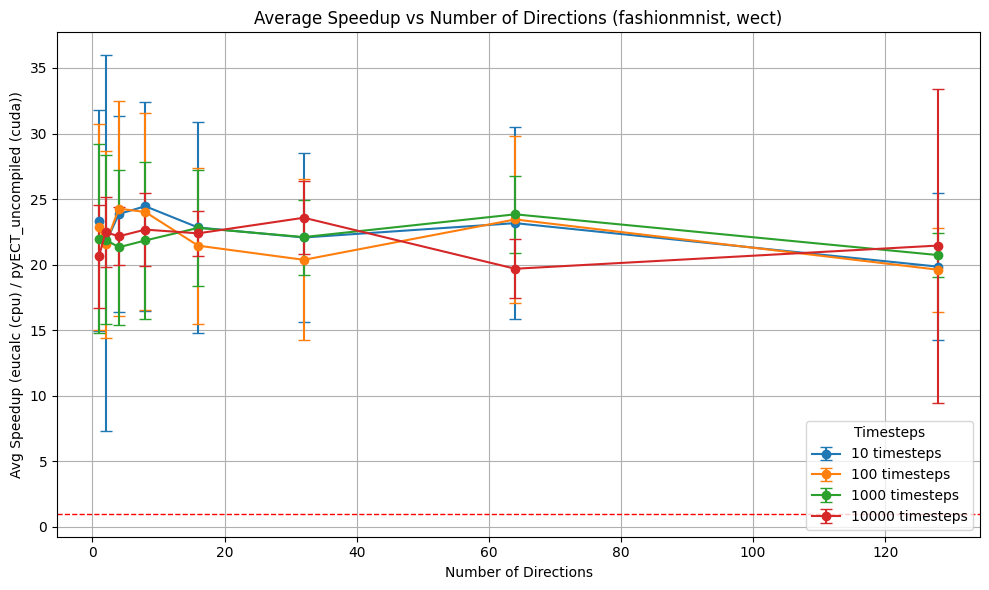

In [4]:
plot_speedup_vs_dirs_multitimesteps(
    dataset="fashionmnist",
    invariant="wect",
    timesteps_list=[10, 100, 1000, 10000],
    dirs_list=[1, 2, 4, 8, 16, 32, 64, 128],
    device_new="cuda",
    device_baseline="cpu",
    cores_new=1,
    cores_baseline=1,
    new_implementation="pyECT_uncompiled",
    baseline_implementation="eucalc"
)


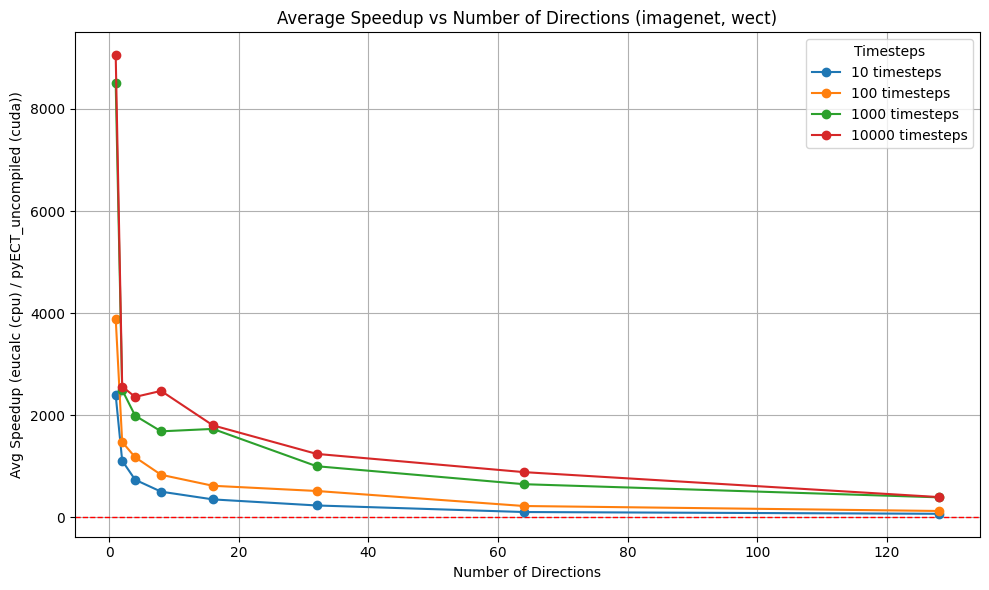

In [5]:
plot_speedup_vs_dirs_multitimesteps(
    dataset="imagenet",
    invariant="wect",
    timesteps_list=[10, 100, 1000, 10000],
    dirs_list=[1, 2, 4, 8, 16, 32, 64, 128],
    device_new="cuda",
    device_baseline="cpu",
    cores_new=1,
    cores_baseline=1,
    new_implementation="pyECT_uncompiled",
    baseline_implementation="eucalc",
    show_err_bars=False
)


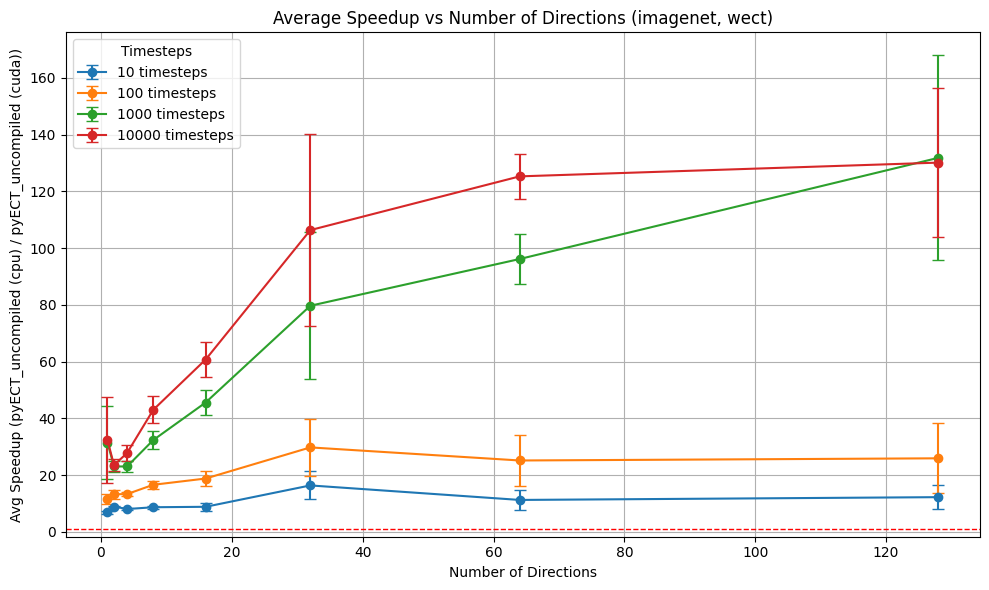

In [6]:
plot_speedup_vs_dirs_multitimesteps(
    dataset="imagenet",
    invariant="wect",
    timesteps_list=[10, 100, 1000, 10000],
    dirs_list=[1, 2, 4, 8, 16, 32, 64, 128],
    device_new="cuda",
    device_baseline="cpu",
    cores_new=1,
    cores_baseline=1,
    new_implementation="pyECT_uncompiled",
    baseline_implementation="pyECT_uncompiled",
    show_err_bars=True
)


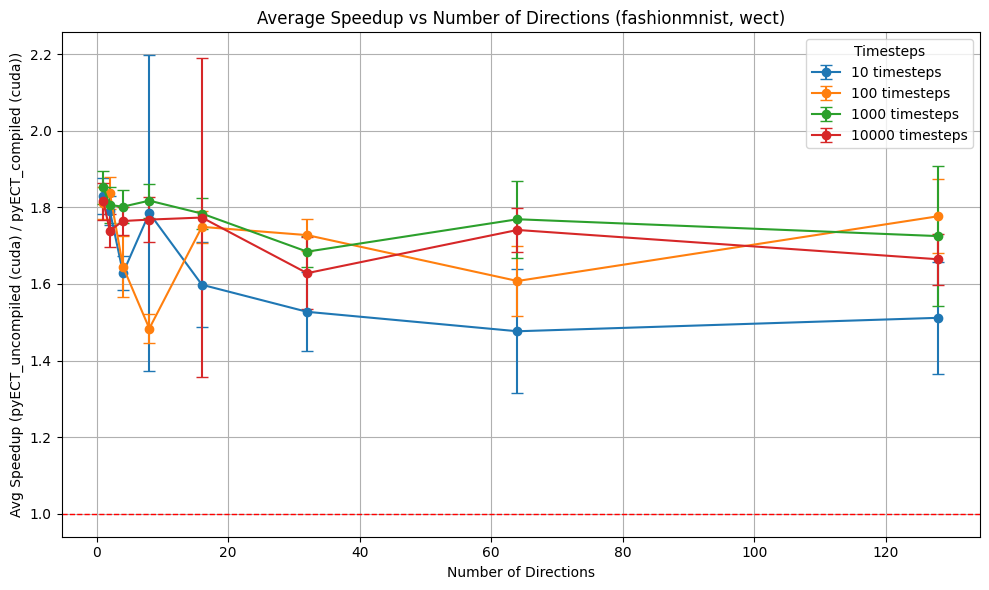

In [7]:
plot_speedup_vs_dirs_multitimesteps(
    dataset="fashionmnist",
    invariant="wect",
    timesteps_list=[10, 100, 1000, 10000],
    dirs_list=[1, 2, 4, 8, 16, 32, 64, 128],
    device_new="cuda",
    device_baseline="cuda",
    cores_new=1,
    cores_baseline=1,
    new_implementation="pyECT_compiled",
    baseline_implementation="pyECT_uncompiled",
    show_err_bars=True
)


In [8]:
import matplotlib.pyplot as plt

def plot_speedup_vs_cores_multitimesteps(
        dataset,
        timesteps_list,
        cores_baseline_list,
        device_new,
        device_baseline,
        cores_new,
        new_implementation="pyECT_uncompiled",
        baseline_implementation="eucalc",
        show_err_bars=True
):
    """
    Plots average speedup = (Baseline time) / (New method time) vs number of cores for the baseline,
    averaged across all images, with error bars showing dataset variability.
    One speedup curve per timestep value.
    
    Assumes invariant="ecf" and num_dirs=0.
    """

    invariant = "ecf"
    num_dirs = 0

    plt.figure(figsize=(10, 6))

    for num_timesteps in timesteps_list:
        mean_speedups = []
        std_speedups = []

        for cores_baseline in cores_baseline_list:

            # Load the dataset for the new method
            df_new = get_dataframe(dataset, invariant, new_implementation,
                                   num_dirs, num_timesteps, device_new, cores_new)

            # Load the dataset for the baseline method
            df_baseline = get_dataframe(dataset, invariant, baseline_implementation,
                                        num_dirs, num_timesteps, device_baseline, cores_baseline)

            # Align by image_index
            df = df_new.merge(df_baseline, on="image_index", suffixes=("_new", "_baseline"))

            # Compute per-image speedup
            per_image_speedup = df["computation_time_baseline"] / df["computation_time_new"]

            # Store statistics
            mean_speedups.append(per_image_speedup.mean())
            std_speedups.append(per_image_speedup.std())

        # Plot with error bars
        plt.errorbar(
            cores_baseline_list,
            mean_speedups,
            yerr=std_speedups if show_err_bars else None,
            marker="o",
            capsize=4,
            label=f"{num_timesteps} timesteps"
        )

    # Reference line for y=1 (no speedup)
    plt.axhline(y=1, color='r', linestyle='--', linewidth=1)

    plt.xlabel(f"Number of Cores ({baseline_implementation})")
    plt.ylabel(f"Avg Speedup ({baseline_implementation} ({device_baseline}) / {new_implementation} ({device_new}))")
    plt.title(f"Average Speedup vs Number of Cores ({dataset}, {invariant})")
    plt.grid(True)
    plt.legend(title="Timesteps")
    plt.tight_layout()
    plt.show()


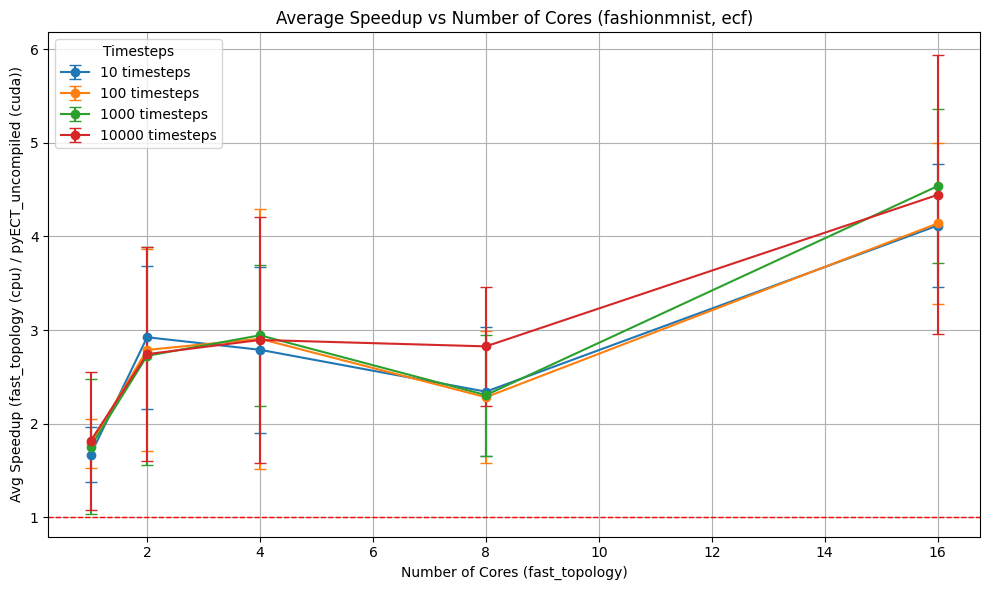

In [9]:
plot_speedup_vs_cores_multitimesteps(
    dataset="fashionmnist",
    timesteps_list=[10, 100, 1000, 10000],
    cores_baseline_list=[1, 2, 4, 8, 16],
    device_new="cuda",
    device_baseline="cpu",
    cores_new=1,
    new_implementation="pyECT_uncompiled",
    baseline_implementation="fast_topology",
    show_err_bars=True
)

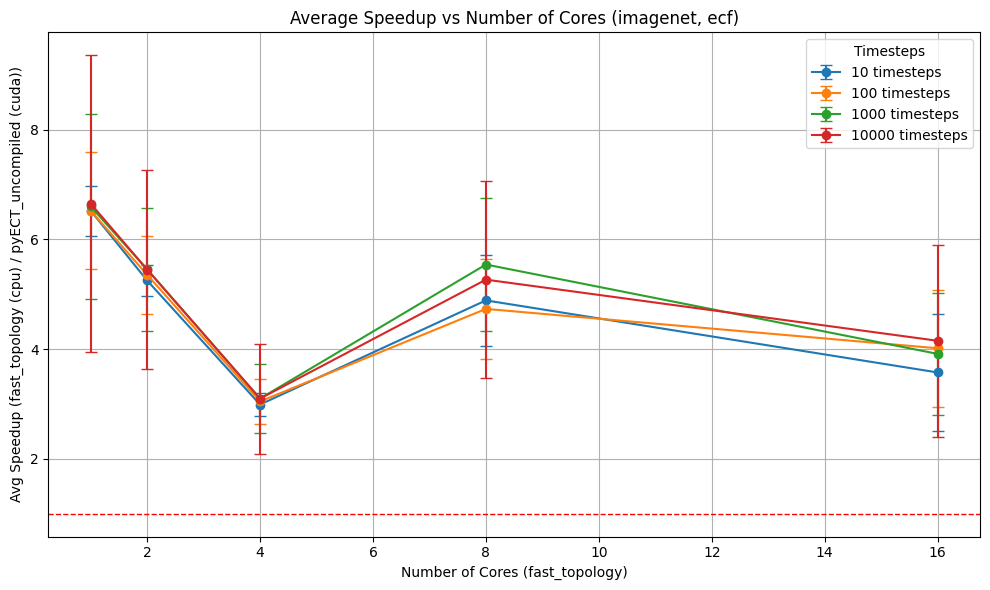

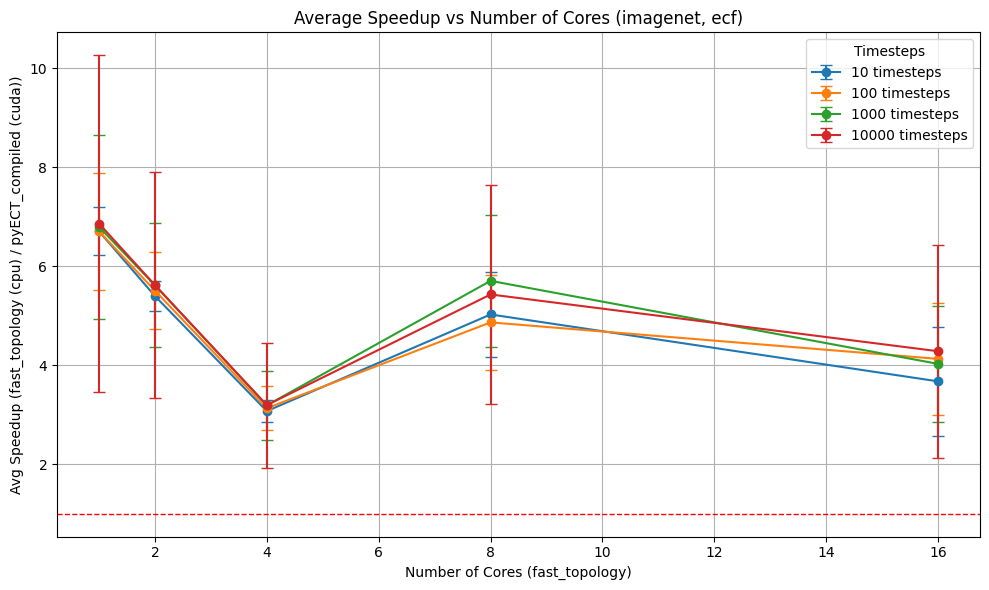

In [10]:
plot_speedup_vs_cores_multitimesteps(
    dataset="imagenet",
    timesteps_list=[10, 100, 1000, 10000],
    cores_baseline_list=[1, 2, 4, 8, 16],
    device_new="cuda",
    device_baseline="cpu",
    cores_new=1,
    new_implementation="pyECT_uncompiled",
    baseline_implementation="fast_topology",
    show_err_bars=True
)

plot_speedup_vs_cores_multitimesteps(
    dataset="imagenet",
    timesteps_list=[10, 100, 1000, 10000],
    cores_baseline_list=[1, 2, 4, 8, 16],
    device_new="cuda",
    device_baseline="cpu",
    cores_new=1,
    new_implementation="pyECT_compiled",
    baseline_implementation="fast_topology",
    show_err_bars=True
)

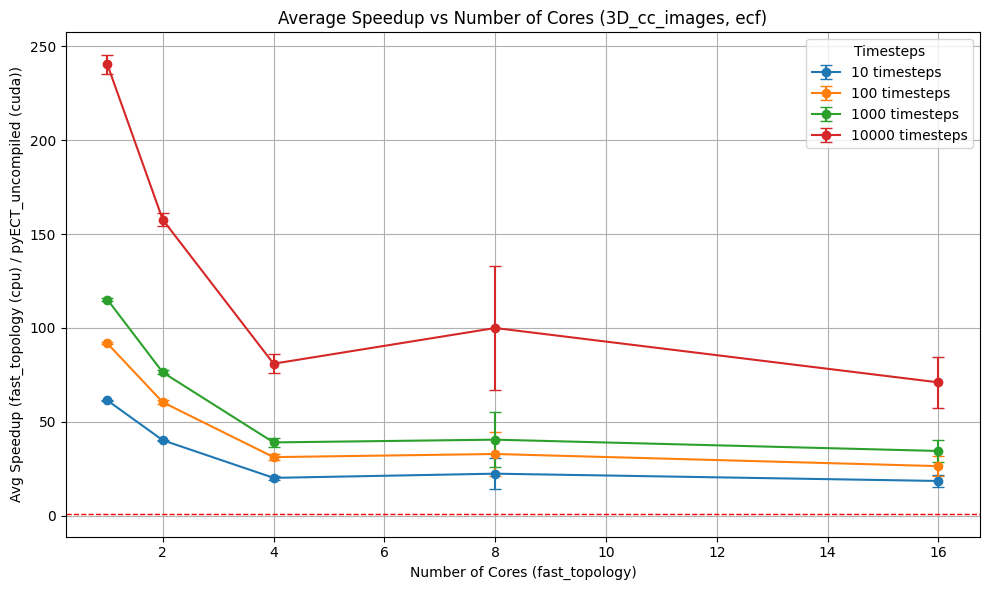

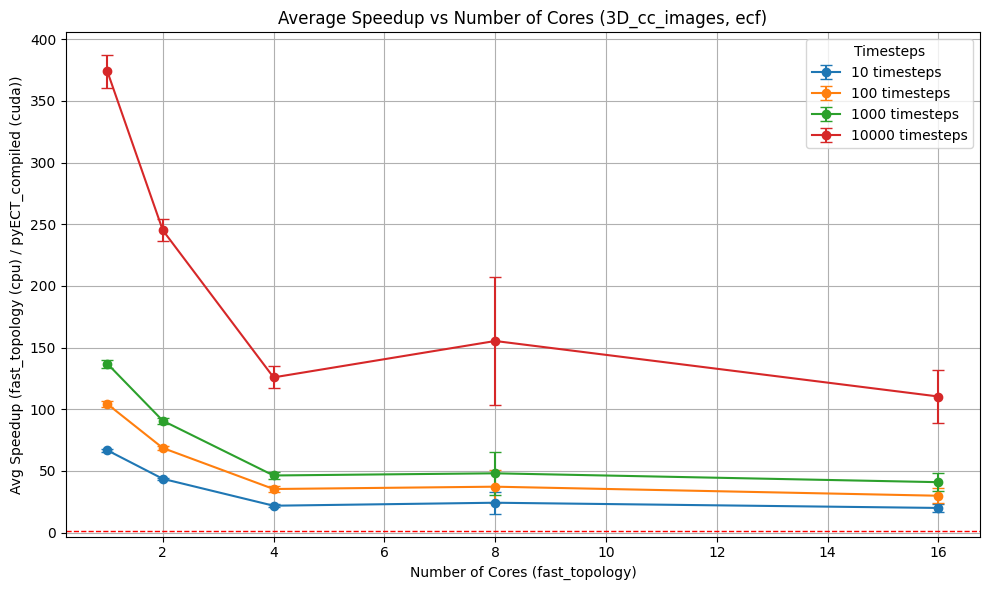

In [11]:
plot_speedup_vs_cores_multitimesteps(
    dataset="3D_cc_images",
    timesteps_list=[10, 100, 1000, 10000],
    cores_baseline_list=[1, 2, 4, 8, 16],
    device_new="cuda",
    device_baseline="cpu",
    cores_new=1,
    new_implementation="pyECT_uncompiled",
    baseline_implementation="fast_topology",
    show_err_bars=True
)

plot_speedup_vs_cores_multitimesteps(
    dataset="3D_cc_images",
    timesteps_list=[10, 100, 1000, 10000],
    cores_baseline_list=[1, 2, 4, 8, 16],
    device_new="cuda",
    device_baseline="cpu",
    cores_new=1,
    new_implementation="pyECT_compiled",
    baseline_implementation="fast_topology",
    show_err_bars=True
)